## PCOD detection using transfer learning model

In [36]:
import numpy as np
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob 
import glob as gb
from PIL import Image
import tensorflow as tf
import imageio
import os
from tensorflow.keras import layers
import time
import pandas as pd
from IPython import display
import cv2
import tensorflow_hub as hub
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image

In [37]:
base_path = '/kaggle/input/pco-dataset/Ultrasound1'

batch_size = 32
img_size = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_path, "train"),
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_path, "val"),
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(base_path, "test"),
    image_size=img_size,
    batch_size=batch_size
)

Found 25838 files belonging to 2 classes.
Found 5536 files belonging to 2 classes.
Found 5538 files belonging to 2 classes.


In [38]:
print("Class names:", train_ds.class_names)

Class names: ['normal', 'pco']


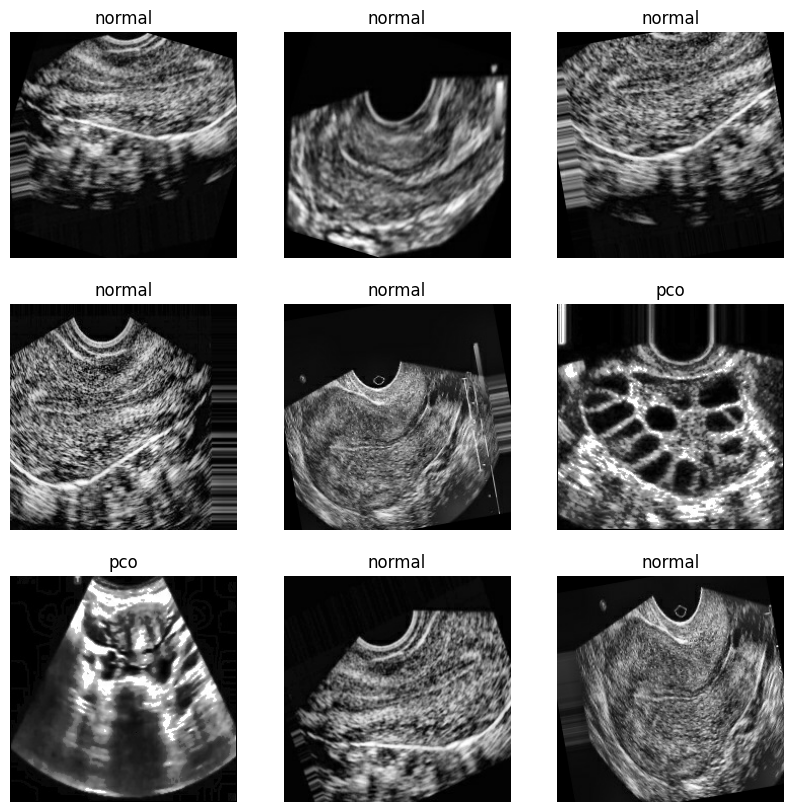

In [39]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [40]:
# scaling images for MobileNet transfer model
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
gray_image = tf.random.uniform((224, 224, 1), minval=0, maxval=255, dtype=tf.float32)
rgb_image = tf.repeat(gray_image, repeats=3, axis=-1)
scaled_image = rescale(rgb_image)

In [41]:
scaled_image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[-0.37593603, -0.37593603, -0.37593603],
        [ 0.38012183,  0.38012183,  0.38012183],
        [-0.24489284, -0.24489284, -0.24489284],
        ...,
        [-0.38290018, -0.38290018, -0.38290018],
        [ 0.8105186 ,  0.8105186 ,  0.8105186 ],
        [-0.04213667, -0.04213667, -0.04213667]],

       [[ 0.7531682 ,  0.7531682 ,  0.7531682 ],
        [-0.97951365, -0.97951365, -0.97951365],
        [-0.67945623, -0.67945623, -0.67945623],
        ...,
        [ 0.9899398 ,  0.9899398 ,  0.9899398 ],
        [-0.32108396, -0.32108396, -0.32108396],
        [-0.5792372 , -0.5792372 , -0.5792372 ]],

       [[-0.10950154, -0.10950154, -0.10950154],
        [-0.28033584, -0.28033584, -0.28033584],
        [-0.1248526 , -0.1248526 , -0.1248526 ],
        ...,
        [ 0.14164698,  0.14164698,  0.14164698],
        [-0.6827333 , -0.6827333 , -0.6827333 ],
        [ 0.36972964,  0.36972964,  0.36972964]],

       ...,

     

### Model 1: MobileNetV2

In [42]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

In [43]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(0.2)
prediction_layer = tf.keras.layers.Dense(len(train_ds.class_names), activation='softmax',
                                         kernel_regularizer=tf.keras.regularizers.l2(0.01))

In [45]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)

In [46]:
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [47]:
len(model.trainable_variables)

2

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
initial_epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs)

Epoch 1/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.7736 - loss: 0.5076 - val_accuracy: 0.9832 - val_loss: 0.1285
Epoch 2/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.9816 - loss: 0.1234 - val_accuracy: 0.9937 - val_loss: 0.0800
Epoch 3/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.9920 - loss: 0.0811 - val_accuracy: 0.9966 - val_loss: 0.0619
Epoch 4/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9955 - loss: 0.0650 - val_accuracy: 0.9975 - val_loss: 0.0519
Epoch 5/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9950 - loss: 0.0561 - val_accuracy: 0.9980 - val_loss: 0.0458
Epoch 6/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.9963 - loss: 0.0499 - val_accuracy: 0.9984 - val_loss: 0.0419
Epoch 7/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.9970 - loss: 0.0449 - val_accuracy: 0.9987 - val_loss: 0.0389
Epoch 8/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9969 - loss: 0.0432 - 

In [50]:
loss0, accuracy0 = model.evaluate(val_ds)
print(f"Validation Loss: {loss0}, Validation Accuracy: {accuracy0}")

173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9995 - loss: 0.0343
Validation Loss: 0.03490416705608368, Validation Accuracy: 0.9990968108177185


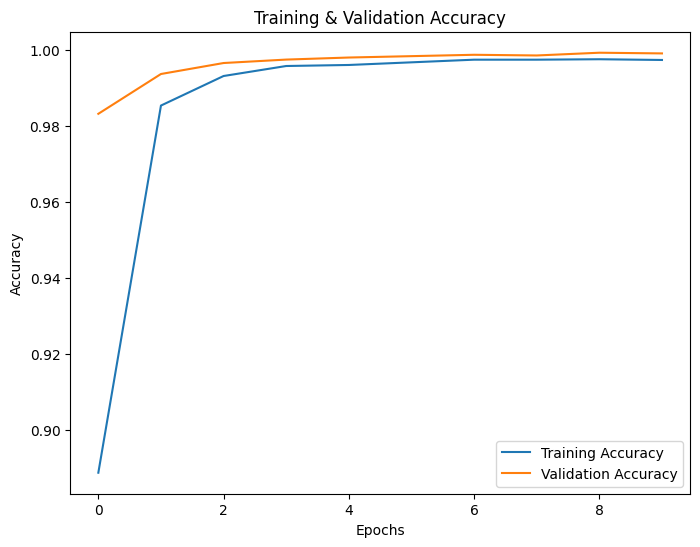

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

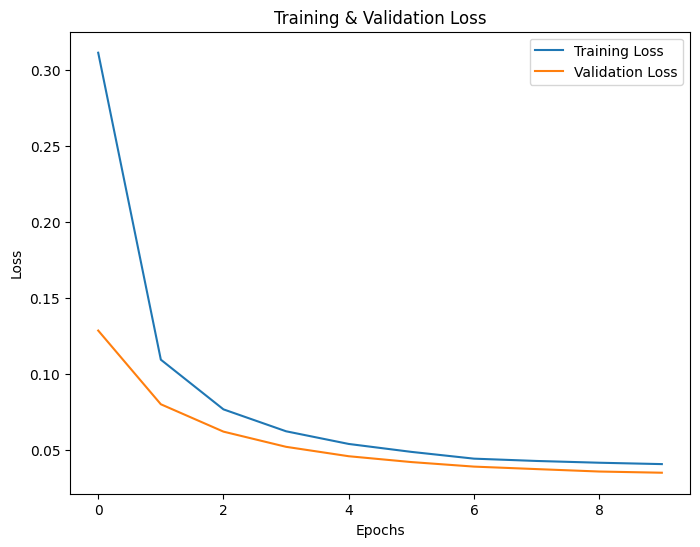

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()


In [53]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9988 - loss: 0.0343
Test accuracy : 0.9990971684455872


Predictions:
 [0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0]
Labels:
 [0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0]


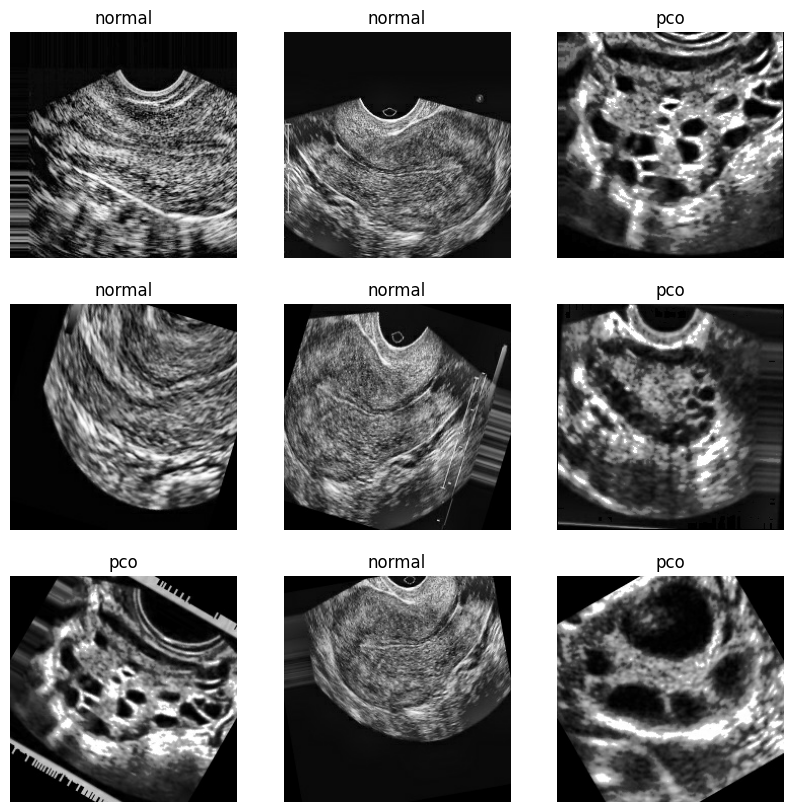

In [54]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions, axis=-1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Model 2: EfficientNetV2B3

In [55]:
base_model2 = keras.applications.EfficientNetV2B3(input_shape=(224, 224, 3),
                                                  include_top=False,
                                                  weights='imagenet'
                                                 )

In [56]:
base_model2.trainable = False
base_model2.summary()

Model: "efficientnetv2-b3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              0 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 16)   │          5,760 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 16)   │          2,304 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 16)   │             64 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 16)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 16)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 16)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_project_activ… │
├──────────────────────

 Total params: 12,930,622 (49.33 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,930,622 (49.33 MB)

In [57]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(0.2)
prediction_layer = tf.keras.layers.Dense(len(train_ds.class_names), activation='softmax',
                                         kernel_regularizer=tf.keras.regularizers.l2(0.01))

In [58]:
inputs2 = tf.keras.Input(shape=(224, 224, 3))
x2 = base_model2(inputs2, training=False)
x2 = global_average_layer(x2)
x2 = dropout_layer(x2)
outputs2 = prediction_layer(x2)

In [59]:
model2 = tf.keras.Model(inputs2, outputs2)
model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b3 (Functional)       │ (None, 7, 7, 1536)          │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           3,074 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,933,696 (49.34 MB)

 Trainable params: 3,074 (12.01 KB)

 Non-trainable params: 12,930,622 (49.33 MB)

In [60]:
len(model2.trainable_variables)

2

In [61]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
initial_epochs = 10
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=initial_epochs)

Epoch 1/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 114s 102ms/step - accuracy: 0.8643 - loss: 0.3724 - val_accuracy: 0.9913 - val_loss: 0.0927
Epoch 2/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 60s 74ms/step - accuracy: 0.9929 - loss: 0.0887 - val_accuracy: 0.9930 - val_loss: 0.0674
Epoch 3/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.9950 - loss: 0.0653 - val_accuracy: 0.9937 - val_loss: 0.0546
Epoch 4/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.9959 - loss: 0.0543 - val_accuracy: 0.9940 - val_loss: 0.0465
Epoch 5/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.9958 - loss: 0.0470 - val_accuracy: 0.9955 - val_loss: 0.0413
Epoch 6/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.9962 - loss: 0.0431 - val_accuracy: 0.9958 - val_loss: 0.0386
Epoch 7/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.9968 - loss: 0.0403 - val_accuracy: 0.9958 - val_loss: 0.0369
Epoch 8/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.9963 - loss: 0.0393 

In [63]:
loss2_0, accuracy2_0 = model2.evaluate(val_ds)
print(f"Validation Loss: {loss2_0}, Validation Accuracy: {loss2_0}")

173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9965 - loss: 0.0333
Validation Loss: 0.03555186465382576, Validation Accuracy: 0.03555186465382576


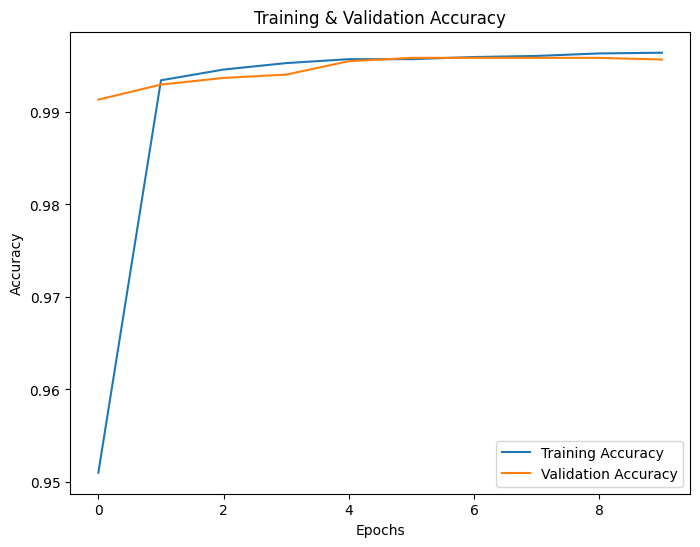

In [64]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

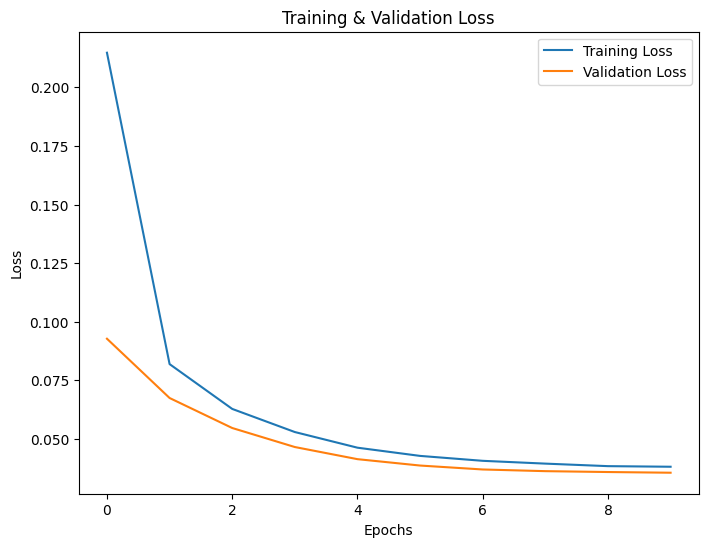

In [65]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

In [66]:
loss2, accuracy2 = model2.evaluate(test_ds)
print('Test accuracy :', accuracy2)

174/174 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.9965 - loss: 0.0338
Test accuracy : 0.9960274696350098


Predictions:
 [0 0 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1]
Labels:
 [0 0 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1]


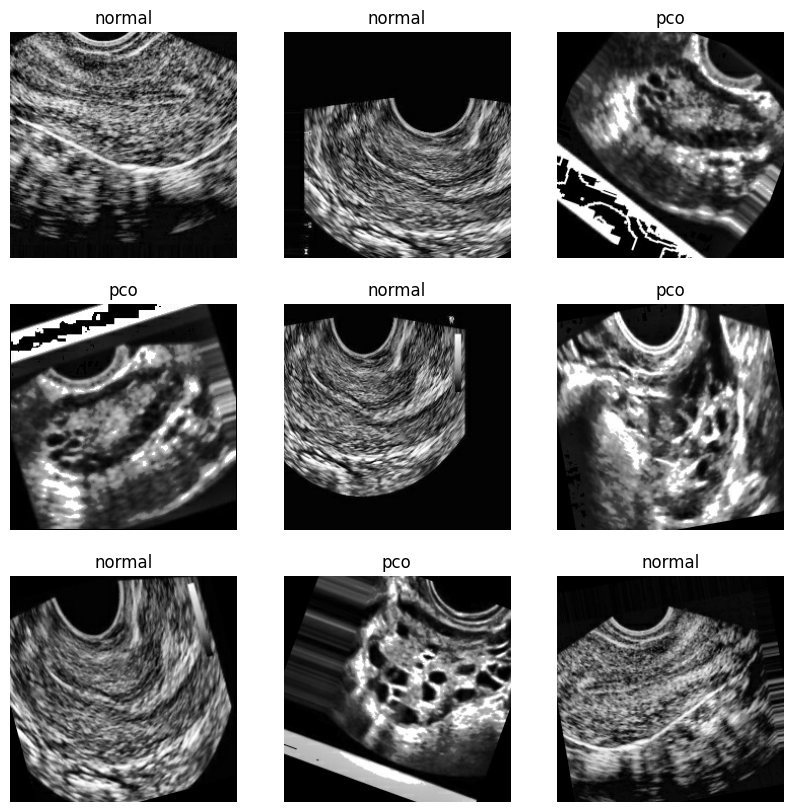

In [68]:
image_batch2, label_batch2 = test_ds.as_numpy_iterator().next()
predictions2 = model2.predict_on_batch(image_batch2)
predictions2 = tf.argmax(predictions2, axis=-1)

print('Predictions:\n', predictions2.numpy())
print('Labels:\n', label_batch2)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch2[i].astype("uint8"))
  plt.title(class_names[predictions2[i]])
  plt.axis("off")